In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from sklearn.preprocessing import PolynomialFeatures

## Functions

In [2]:
def sigmoid_logistic_function(z): # sigmoid function: logistic function

    # These two lines in loops are useful to prevent overflows...
    if z < -45:
        return 0.
    elif z > 45:
        return 1.

    else:
        return 1. / (1. + np.exp(-1.*z) )
sigmoid_logistic_function = np.vectorize(sigmoid_logistic_function)

In [3]:
def hypothesis(theta, X): # hypothesis for logistic regression

    return sigmoid_logistic_function(np.dot(X,theta))

In [4]:
# Computes and returns the total regularized cost function for logistic regression

def compute_cost(theta, X, y, lam_reg): 

    h = hypothesis(theta,X) # hypothesis

    m = y.size # Number of training examples

    J_0 = np.nan_to_num( -y*np.log(h) ) 
    J_1 = np.nan_to_num( (1.-y)*np.log(1.-h) )

    J = 1./m * np.sum( J_0 - J_1 ) +  lam_reg/(2.*m) * np.sum(theta[1:]**2.)  # Regularized cost function: mean on the training examples of the log-likelihood vector

    return J

In [5]:
# Computes and returns the gradient of the regularized cost function for logistic regression (derivatives with 
# respect to the weights theta)

def compute_grad(theta, X, y, lam_reg):

    h = hypothesis(theta,X) # hypothesis
    error = h - y # difference between label and prediction

    m = y.size # Number of training examples

    grad = np.empty(theta.size) # initializing the gradient vector

    grad[0] = 1./m * np.dot(error, X[:,0]) # gradient ( not regularized for j=0)
    grad[1:] = 1./m * np.dot(error, X[:,1:]) + 1.*lam_reg/m * theta[1:] # regularized gradient (for j >= 1 )

    return grad

In [6]:
# Scales the feature x to have approximately zero mean and in range [-1,1].
# Returns the scaled vector x, its mean x_mean, and its standard deviation x_std

def feature_scaling(x): 

    x_mean = np.mean(x) # Feature mean
    x_std = np.std(x)   # Feature standard deviation

    return (x - x_mean) / x_std, x_mean, x_std

In [7]:
def confusion_matrix(h, Y, eps):

    TP = 1.*np.size( np.where( (h > eps) & (Y == 1) ) )  # number of True Positives
    FP = 1.*np.size( np.where( (h > eps) & (Y == -1) ) ) # number of False Positives
    FN = 1.*np.size( np.where( (h < eps) & (Y == 1) ) )  # number of False Negatives
    TN = 1.*np.size( np.where( (h < eps) & (Y == -1) ) ) # number of True Negatives

    return TP, FP, FN, TN

In [8]:
def F1_score(TP,FP,FN): # F1 score, [0,1]

    P = TP / (TP + FP) # Precision: True Positives / Actual Positives
    R = TP / (TP + FN) # Recall: True Positives / Predicted Positives

    F1 = 2.*P*R / (P+R) # F1 score

    return F1

## Reading and plotting the dataset

In [9]:
x1, x2, y = np.genfromtxt('data.txt', delimiter=',', unpack=True)

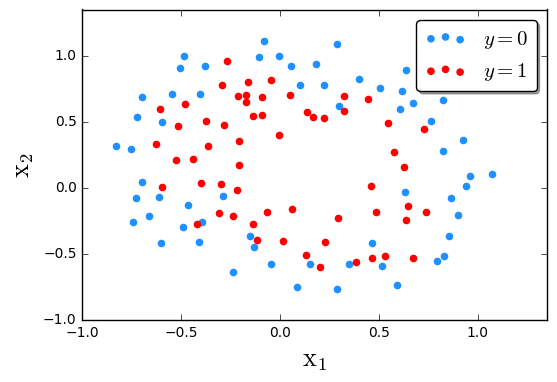

In [10]:
plt.scatter(x1[y==0], x2[y==0], color='dodgerblue',label=r'$y = 0$')
plt.scatter(x1[y==1], x2[y==1], color='red',label=r'$y = 1$')
plt.xlabel(r'$\mathrm{x_1}$', fontsize=19)
plt.ylabel(r'$\mathrm{x_2}$', fontsize=19)
plt.legend(fancybox=True, shadow=True, fontsize=15)
plt.xlim([-1., 1.35])
plt.ylim([-1., 1.35])
plt.show()

## Dataset Creation

In [11]:
X = np.concatenate((x1, x2))
X = X.reshape(2,len(x1)).T # (len_dataset x 2) Matrix

pol_degree = 5 # Defines the degree of the polynomial for feature mapping
poly = PolynomialFeatures(pol_degree) 

X_s = poly.fit_transform(X) # (Already includes the x0 = 1 feature)

M,n = X_s.shape # M: total number of examples in the dataset, n: number of features

n = n-1 # Exclude the bias unit in the number of features

print 'Number of features: %s' %int(n)
print 'Number of training examples: %s' %int(M)

Number of features: 20
Number of training examples: 118


In [12]:
# Future Scaling: make features have approximately zero mean and in range [-1, 1]

X_mean = np.empty(n+1) # Mean feature vector
X_std = np.empty(n+1) # Standard deviation feature vector

# Values for the intercept term x0 
X_mean[0] = 0.
X_std[0] = 1.

for k in range(1, n+1): # Do NOT include x0 = 1 

    X_s[:,k], X_mean[k], X_std[k] = feature_scaling(X_s[:,k])

## Logistic Regression!

In [13]:
# (Hyper) parameters of the algorithm

alpha = 0.1     # Learning rate for gradient descent
err_thr = 1.e-6 # Threshold for ending the gradient descent loop
lam_reg = 1.    # Regularization parameter

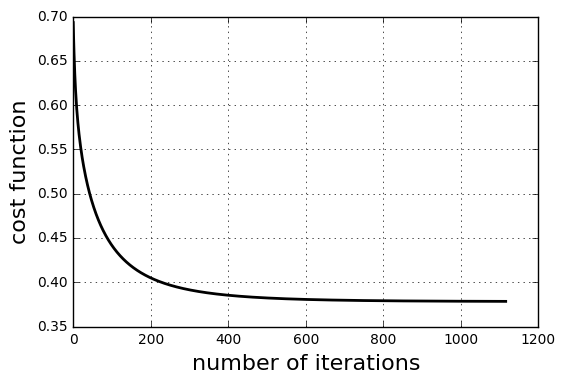

In [14]:
# Initializing the parameters:
#theta = 0.1 * np.random.rand(np.size(X_s[0])) # Random values in [0, 0.1]
theta = np.zeros(np.size(X_s[0])) # Zeroes

J = []

J.append(compute_cost(theta, X_s, y, lam_reg)) # Initial value for the cost function
err = 1

# Gradient descent:
i = 0
while err > err_thr:

    i+=1

    theta = theta - alpha*compute_grad(theta, X_s, y, lam_reg) # updating parameters..

    J.append(compute_cost(theta, X_s, y, lam_reg)) # Cost function	

    err = (J[i-1] - J[i])

    if err < 0:
        print '!!!Cost function is increasing... something is wrong!!! ...try decreasing alpha'
        sys.exit()
        
# A plot to chech that, with gradient descent, the cost function is actually decreasing after each iteration...
cont = np.arange(0,len(J),1)

plt.figure(3)
plt.plot(cont,J,linewidth=2,color='black')
plt.xlabel('number of iterations', fontsize=16)
plt.ylabel('cost function', fontsize=16)
plt.grid()
plt.show()


In [15]:
hyp = hypothesis(theta, X_s) # Hypthesis on the training set

## Results!

In [16]:
TP, FP, FN, TN = confusion_matrix(hyp, y, eps=0.5) # Confusion matrix
F1 = F1_score(TP, FP, FN) # Performance metric: F1 Score

print 'F_1 score = %s' %round(F1, 2)

F_1 score = 0.93


## Plotting the decision boundary (hyp = 0.5)

In [17]:
# Create a grid in x1, x2 space 

Num = 500

xmin = x1.min()-1
xmax = x1.max()+1

x1grid = np.linspace(xmin, xmax, Num)
x2grid = np.linspace(xmin, xmax, Num)

xx, yy = np.meshgrid(x1grid, x2grid)
X_grid = np.c_[ np.ravel(xx), np.ravel(yy) ]

In [18]:
# Feature scaling on the grid data

Xg_s = poly.fit_transform(X_grid) # (Already includes the x0 = 1 feature)

Xg_s = (Xg_s- X_mean)/X_std

In [19]:
# Hypothesis on the grid data

hyp_g = hypothesis(theta, Xg_s)
hyp_g = hyp_g.reshape(xx.shape)

/software/local/lib64/python2.7/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/software/local/lib64/python2.7/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


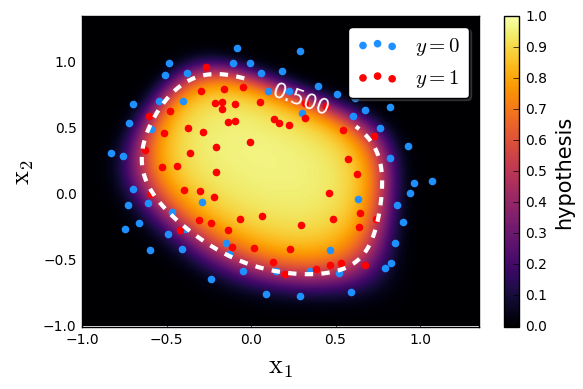

In [20]:
cs = plt.imshow( hyp_g, extent=[xx.min(), xx.max(), yy.min(), yy.max()], origin='lower',cmap='inferno', aspect='auto')
plt.scatter(x1[y==0], x2[y==0], color='dodgerblue',label=r'$y = 0$')
plt.scatter(x1[y==1], x2[y==1], color='red',label=r'$y = 1$')
CS=plt.contour(xx, yy, hyp_g, colors='white',linewidths=3, linestyles='dashed', levels =[0.5])
plt.clabel(CS,  fontsize=15)
plt.xlabel(r'$\mathrm{x_1}$', fontsize=19)
plt.ylabel(r'$\mathrm{x_2}$', fontsize=19)
plt.legend(fancybox=True, shadow=True, fontsize=15)
cbar = plt.colorbar(cs)
cbar.ax.set_ylabel('hypothesis', fontsize=15)
plt.xlim([-1., 1.35])
plt.ylim([-1., 1.35])
plt.tight_layout()
plt.show()